# Exercise 01: SVD and Dimensionality Reduction

In this exercise, you will explore a "high-dimensional" (D=5) dataset
and determine:
* whether or not a good low-dimensional representation exists
* whether or not the data is linearly separable

As usual, let's start by installing and importing the stuff we'll need:

In [89]:
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U scikit-learn matplotlib seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 59.5 MB/s eta 0:00:00m eta 0:00:010:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 71.4 MB/s eta 0:00:000m eta 0:00:0136m0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.0
    Uninstalling scikit-learn-1.4.0:
      Successfully uninstalled scikit-learn-1.4.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.2
    Uninstalling matplotlib-3.8.2:
      Successfully uninstalled matplotlib-3.8.2


In [90]:
import numpy as np
import matplotlib.pyplot as plt

Now we'll create some data to analyze.

You don't need to understand this code in detail,
but you might want to revisit it after you finish the exercise
to see if you can figure out what I did and why I did it.

In [91]:
## create a 5D normal unit vector
n = np.array([[0.5, 0.5, 0.5, 0.5, 0.5]]).T #np.random.rand(5,1)
n_hat = n / np.linalg.norm(n)
d = 10.0*np.random.rand(1,1)

## create two unit vectors normal to n_hat
a_1      = np.array([[0.5, -0.5, -0.5, -0.5, 0.5]]).T #np.random.rand(5,1)
a_1_orth = a_1 - np.dot(n_hat.T, a_1)*n_hat
a_1_hat  = a_1_orth / np.linalg.norm(a_1_orth)

a_2            = np.array([[-0.5, 0.5, 0.5, 0.5, -0.5]]).T #np.random.rand(5,1)
a_2_orth_1     = a_2 - np.dot(n_hat.T, a_2)*n_hat
a_2_orth_2     = a_2_orth_1 - np.dot(a_1_hat.T, a_2_orth_1)*a_1_hat
a_2_hat        = a_2_orth_2 / np.linalg.norm(a_2_orth_2)

print('n_hat =\n{}'.format(n_hat))
print('a_1_hat =\n{}'.format(a_1_hat))
print('a_2_hat =\n{}'.format(a_2_hat))

n_hat =
[[0.4472136]
 [0.4472136]
 [0.4472136]
 [0.4472136]
 [0.4472136]]
a_1_hat =
[[ 0.54772256]
 [-0.36514837]
 [-0.36514837]
 [-0.36514837]
 [ 0.54772256]]
a_2_hat =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]]


In [92]:
## create clusters of random data
np.random.seed(10)

cluster_infos = [
    ( 0.0, 0.0, 0.2, 1),
    (+6.0, 0.0, 0.7, 2),
    (-6.0, 0.0, 0.7, 3),
    (+2.0,+2.0, 0.2, 4),
    (+2.0,-2.0, 0.2, 5),
    (-2.0,+2.0, 0.2, 6),
    (-2.0,-2.0, 0.2, 7),
]
N_samples = 100

coord_offset = np.array([[3.0, 0.0, -9.0, 4.0, 30.0]])

all_samples = [];
for (coord_1,coord_2,sigma,categ) in cluster_infos:
    m = coord_1*a_1_hat + coord_2*a_2_hat
    C = np.diagflat(sigma*sigma*np.ones((1,5)))
    samples = np.random.default_rng().multivariate_normal(np.zeros((5,)), C, N_samples) + m.T + coord_offset;
    samples = np.concatenate((samples,categ*np.ones((samples.shape[0],1))), axis=1)
    all_samples.append(np.copy(samples))
    
samples = np.concatenate(all_samples, axis=0)
sample_data = samples[:,0:5]
sample_targets = samples[:,5]

Each row of `samples` contains one 5D data point and a classification category: 

In [93]:
samples.shape

(700, 6)

Let's convert `samples` to a pandas dataframe and take a look at it.

In [94]:
import pandas as pd
import seaborn as sns

sns.set(style='ticks', color_codes=True)
df = pd.DataFrame(
    data=samples,
    columns=['c_'+str(n) for n in range(5)] + ['target']
)

/tmp/ipykernel_29565/3607304137.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [95]:
df

,c_0,c_1,c_2,c_3,c_4,target
0,2.952830,-0.083226,-9.103479,3.742955,29.924029,1.0
1,3.231710,-0.066665,-9.264759,4.369172,30.071132,1.0
2,2.873603,0.495006,-9.321427,3.996885,29.848839,1.0
3,2.952888,-0.002039,-8.974259,4.024510,30.111442,1.0
4,3.477492,0.261554,-8.850502,3.851694,29.818848,1.0
...,...,...,...,...,...,...
695,0.463077,0.771107,-8.365882,4.675304,27.466481,7.0
696,0.751850,0.807547,-8.284985,4.591344,27.428979,7.0
697,0.717469,0.793436,-8.608856,4.905826,27.217513,7.0
698,0.468502,0.574444,-7.971429,4.857501,27.415418,7.0


Time for some `pairplots`:

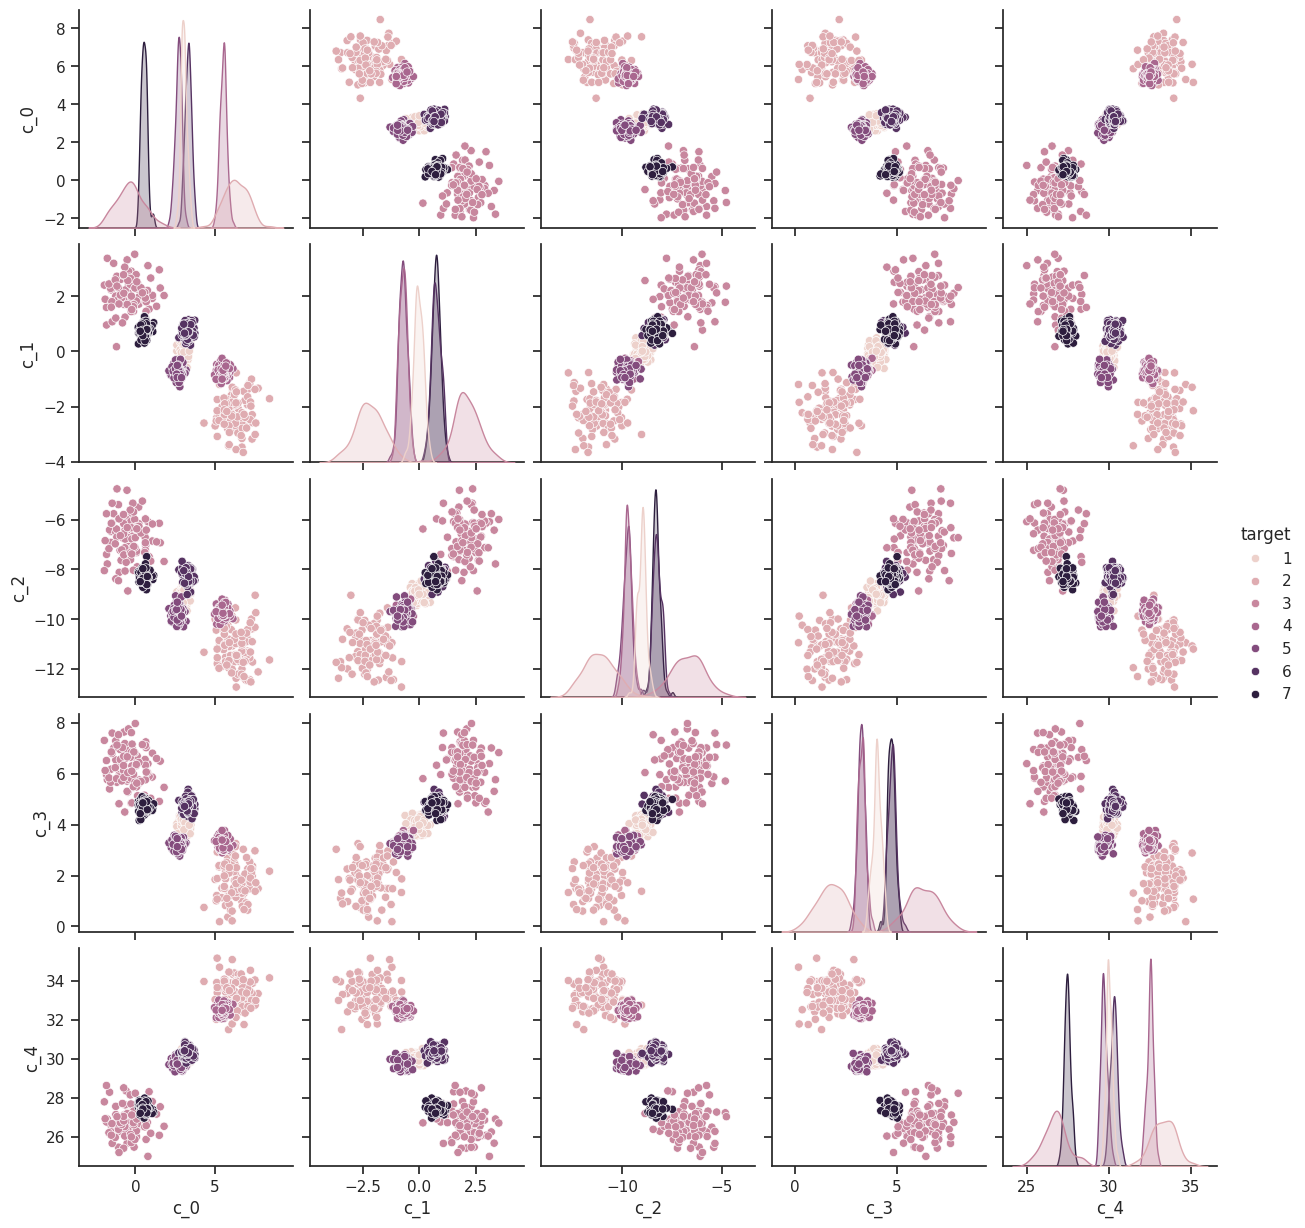

In [96]:
g = sns.pairplot(df, hue='target');

**Based on the above plots, are the categories separable?  Why or why not?**

YOUR ANSWER HERE.

Yes these categories are separable because the peaks for the c_x and c_x graphs are different which allow it to be seperated once its lowered to 3 or less dimensions

Let's see if we can reduce the dimensionality of this data
by applying Singular Value Decomposition (SVD)
to its covariance matrix:

In [97]:
M = sample_data;
CM = np.dot(M.T, M)
U,S,Vh = np.linalg.svd(CM,full_matrices=True, compute_uv=True)

In [102]:
S

array([7.09089328e+05, 5.78042810e+03, 5.88864813e+02, 1.22456018e+02,
       1.05773836e+02])

**Based on the singular values in the `S` vector above,
what's the smallest number of dimensions we can keep
and still retain the vast majority of the data's information content?
How did you arrive at that value?**

YOUR ANSWER HERE.

2 because we can get rid of the smallest values to the power of 2

Let's see what happens if we retain only 2 dimensions...

We'll create a new matrix using the first 2 singular values:

In [99]:
P = np.dot(np.diagflat(S[0:2]), Vh[0:2,:])

In [105]:
P

array([[-7.09479359e+04,  2.19429119e+03,  2.01822164e+05,
        -8.67891518e+04, -6.70451123e+05],
       [ 3.91365620e+03, -2.48718916e+03, -1.18351215e+03,
        -3.22166755e+03, -3.61512760e+02]])

**What is the shape of `P`?  What does that tell us about the effect `P` has on its inputs?  What does this matrix do for us?** (Hint: Why did I call it `P`?)

YOUR ANSWER HERE.

the shape of P is a 2x5 matrix. This matrix is the one that we dot with x to get the reduced dimension matrix y.

Let's apply `P` to our data and take a look at the 2D scatterplot.

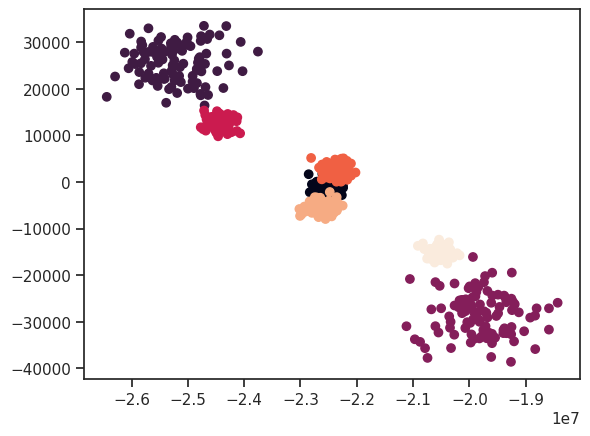

In [106]:
new_data = np.dot(P,M.T)
plt.scatter(new_data[0,:], new_data[1,:], c=samples[:,5]);

**Based on the above plot, did our use of SVD significantly improve the separability of our data?  Why or why not?**

YOUR ANSWER HERE.

Not a significant amount of improvement was made from the SVD. This could be because values from the S array that we got rid of wasnt that far off from the data we kept. Also we didnt normalize the data before transforming it.

Our original data wasn't centered at the origin nor were the axes scaled by their standard deviations.  Let's do that now and see if it impacts the results:

In [107]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(sample_data)
scaled_sample_data = scaler.transform(sample_data)
scaled_samples = np.concatenate((scaled_sample_data,samples[:,5:6]), axis=1)

In [108]:
M = scaled_sample_data;
CM = np.dot(M.T, M)
U,S,Vh = np.linalg.svd(CM,full_matrices=True, compute_uv=True)

In [109]:
S

array([3111.37849594,  238.73279565,   64.01335225,   60.83164416,
         25.043712  ])

**Based on the singular values above, what is a reasonable estimate of the number of useful data dimensions?**

YOUR ANSWER HERE.

1 to 2 dimensions are useful

Let's take a look at the new 2D scatter plot:

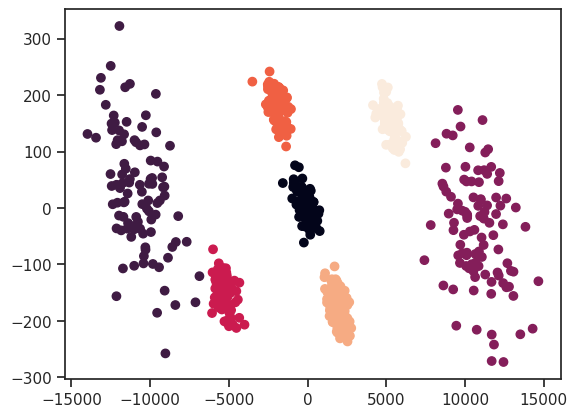

In [110]:
P = np.dot(np.diagflat(S[0:2]), Vh[0:2,:])
new_M = np.dot(P,M.T)
plt.scatter(new_M[0,:], new_M[1,:], c=samples[:,5]);

**Based on the above plot, is our data representable in 2D?  Is it separable in 2D?**

YOUR ANSWER HERE.

it is more separable and theres no overlap of data which makes potential clustering easier

**Why did data normalization have such a large impact on SVD?**

YOUR ANSWER HERE.

SVD requires a pass through the origin and normalizing the data will allow better results.

**Is this reduction from 5D to 2D lossy or lossless?** (Feel free to google those terms if you need to.)

YOUR ANSWER HERE.

the reduction is lossless because it can be turned back into 5D from 2D

**Why would we want to reduce the dimensionality of our data? What advantages does it bring, if any?  What disadvantages?**

YOUR ANSWER HERE.

reducing the dimensions allows better visulization of the data and allows for easier separability of the classes.

**What did you think of this exercise?**

YOUR ANSWER HERE.

I enjoyed it and though it gave good practice for SVD